# Асинхронное программирование в Python

https://medium.com/analytics-vidhya/asyncio-threading-and-multiprocessing-in-python-4f5ff6ca75e8

## Определения

__Поток__ - наименьшая единица обработки, которую может назначить ядро операционной системы. Несколько потоков могут исполняться внутри одного процесса.

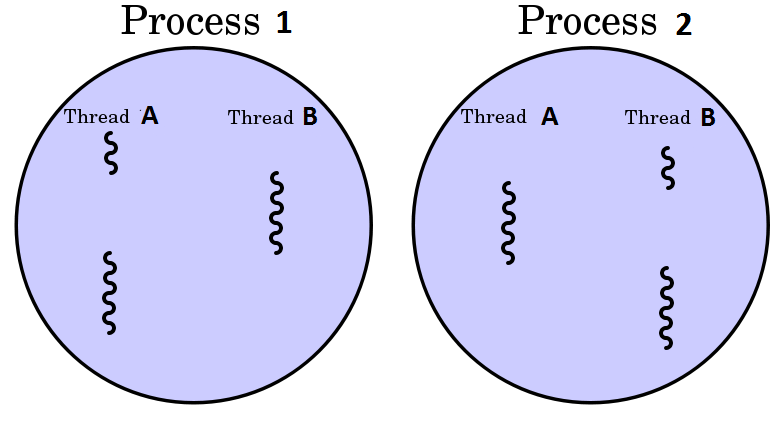

__Процесс__ — экземпляр программы во время выполнения, независимый объект, которому выделены системные ресурсы.

Практическая разница между ними заключается в том, что процессы не делят между собой память (т.е. у каждого процесса свой контекст исполнения, и они не могут обращаться к переменным друг друга), а разные потоки могут взаимодействовать с одними и теми же ресурсами.

## GIL - Global Interpreter Lock

В многопоточном приложении сразу несколько потоков могут изменять счетчик ссылок на объект, а это может привести к его непредвиденному удалению. Блокировка счетчика ссылок отдельных объектов - плохой вариант, поскольку это может привести к взаимной блокировке двух объектов. Поэтому в питоне используется GIL - глобальная блокировка самого интерпретатора. Таким образом, многопоточные приложения всё равно исполняются последовательно.

# Общие концепты

# Многопоточность

Несмотря на последовательное исполнение всех потоков в интерпретаторе, многопоточность несет в себе смысл. Иногда в коде появляются долгие операции, которые приостанавливают собой всё остальное выполнение программы. Их нужно выносить в отдельный поток, чтобы остальная часть программы могла исполняться в прерываниях того потока.

Напишем простую однопоточную программу:

In [25]:
import logging
import time

logger_format = '%(asctime)s:%(threadName)s:%(message)s'
logging.basicConfig(format=logger_format, level=logging.INFO, datefmt="%H:%M:%S")


def delay(delay, message):
    logging.info(f"{message} received")
    time.sleep(delay)
    logging.info(f"Printing {message}")
    return message

def main():
    logging.info("Main started")
    delay(2, "TWO SECONDS DELAY")
    delay(3, "THREE SECONDS DELAY")
    logging.info("Main Ended")

    
main()

17:23:28:MainThread:Main started
17:23:28:MainThread:TWO SECONDS DELAY received
17:23:30:MainThread:Printing TWO SECONDS DELAY
17:23:30:MainThread:THREE SECONDS DELAY received
17:23:33:MainThread:Printing THREE SECONDS DELAY
17:23:33:MainThread:Main Ended


Запишем ту же логику с использованием модуля threading, который отвечает за работу с потоками. Получим 2 секунды выигрыша, поскольку прерывание исполнения и передача управления другому потоку происходит во время "сна" потока.

In [26]:
import threading

def main():
    logging.info("Main started")
    threads = [
        threading.Thread(target=delay, args=(3, "THREE SECONDS DELAY")),
        threading.Thread(target=delay, args=(2, "TWO SECONDS DELAY")),
    ]
    for thread in threads:
        thread.start()
    logging.info("А тут мы видим, что главный поток тоже продолжает исполняться")
    for thread in threads:
        thread.join() # waits for thread to complete its task
    logging.info("Main Ended")
    
main()

17:23:33:MainThread:Main started
17:23:33:Thread-4:THREE SECONDS DELAY received
17:23:33:Thread-5:TWO SECONDS DELAY received
17:23:33:MainThread:А тут мы видим, что главный поток тоже продолжает исполняться
17:23:35:Thread-5:Printing TWO SECONDS DELAY
17:23:36:Thread-4:Printing THREE SECONDS DELAY
17:23:36:MainThread:Main Ended


### Футуры

Создание потоков - достаточно затратная операция, поэтому под каждый вызов функции создавать свой поток - долго. Футуры позволяют создать пул потоков, в котором отработавшие потоки будут переиспользоваться в новых заданиях. В них хранится текущий результат выполнения какой-либо задачи.

In [27]:
import concurrent.futures as cf

def main():
    with cf.ThreadPoolExecutor(max_workers=2) as executor:
        future_to_mapping = {
            executor.submit(delay, 3, "THREE SECONDS DELAY"): "3 secs",
            executor.submit(delay, 2, "TWO SECONDS DELAY"): "2 secs",
            executor.submit(delay, 4, "FOUR SECONDS DELAY"): "4 secs",
        }
        for future in cf.as_completed(future_to_mapping):
            logging.info(f"{future.result()} Done")
            
main()

17:23:36:ThreadPoolExecutor-1_0:THREE SECONDS DELAY received
17:23:36:ThreadPoolExecutor-1_1:TWO SECONDS DELAY received
17:23:38:ThreadPoolExecutor-1_1:Printing TWO SECONDS DELAY
17:23:38:ThreadPoolExecutor-1_1:FOUR SECONDS DELAY received
17:23:38:MainThread:TWO SECONDS DELAY Done
17:23:39:ThreadPoolExecutor-1_0:Printing THREE SECONDS DELAY
17:23:39:MainThread:THREE SECONDS DELAY Done
17:23:42:ThreadPoolExecutor-1_1:Printing FOUR SECONDS DELAY
17:23:42:MainThread:FOUR SECONDS DELAY Done


# Asyncio

Библиотека, которая появилась в Python 3.4 и позволяет создавать асинхронные приложения с минимальными усилиями. В asyncio используются три основные сущности:

1. __Корутины__ - специальные функции, от которых ожидается передача управления в цикл событий, из которого они были запущены.
2. __Цикл событий__ - корутина, которая управляет вызовом остальных корутин.
3. __Awaitable объект__ - объект, который умеет "ожидать" результат.

Корутины можно задавать в стиле генератора:

In [28]:
def grep(pattern):
    print("Searching for", pattern)
    while True:
        line = (yield)
        if pattern in line:
            print(line)
            
            
search = grep('coroutine')
print("grep:", type(grep))
print("search:", type(search))
print()

next(search)
search.send("I love you")
search.send("Don't you love me?")
search.send("I love coroutines instead!")
search.close()

grep: <class 'function'>
search: <class 'generator'>

Searching for coroutine
I love coroutines instead!


Но лучше для этого использовать ключевые слова `async def`, которые появились в Python 3.5.

In [29]:
import asyncio
import time


async def delay_message(delay, message):
    logging.info(f"{message} received")
    await asyncio.sleep(delay) # time.sleep is blocking call. Hence, it cannot be awaited and we have to use asyncio.sleep
    logging.info(f"Printing {message}")
    
    
print(type(delay_message))
print(type(delay_message(2, "TWO SECONDS AWAIT")))

<class 'function'>
<class 'coroutine'>


<ipython-input-29-9cfab087dae6>:12: RuntimeWarning: coroutine 'delay_message' was never awaited
  print(type(delay_message(2, "TWO SECONDS AWAIT")))


In [30]:
async def main():
    logging.info("Main started")
    logging.info(f'Текущие зарегистрированные задания: {len(asyncio.all_tasks())}')
    logging.info("Создадим задания")
    task_1 = asyncio.create_task(delay_message(2, "TWO SECONDS AWAIT") )
    task_2 = asyncio.create_task(delay_message(3, "THREE SECONDS AWAIT"))
    logging.info(f'Текущие зарегистрированные задания: {len(asyncio.all_tasks())}')
    await task_1
    await task_2
    logging.info("Main Ended")

# asyncio.run(main()) # creates an event loop
    
await main()

17:23:42:MainThread:Main started
17:23:42:MainThread:Текущие зарегистрированные задания: 1
17:23:42:MainThread:Создадим задания
17:23:42:MainThread:Текущие зарегистрированные задания: 3
17:23:42:MainThread:TWO SECONDS AWAIT received
17:23:42:MainThread:THREE SECONDS AWAIT received
17:23:44:MainThread:Printing TWO SECONDS AWAIT
17:23:45:MainThread:Printing THREE SECONDS AWAIT
17:23:45:MainThread:Main Ended


Еще удобней использовать `asyncio.gather` для создания заданий:

In [31]:
async def main():
    logging.info("Main started")
    logging.info("Создаем несколько заданий с помощью asyncio.gather")
    await asyncio.gather(*[delay_message(i, f"WAITING {i} SECONDS") for i in range(6, 0, -1)])
    logging.info("Main Ended")
    

# asyncio.run(main()) # creates an event loop

await main()

17:23:45:MainThread:Main started
17:23:45:MainThread:Создаем несколько заданий с помощью asyncio.gather
17:23:45:MainThread:WAITING 6 SECONDS received
17:23:45:MainThread:WAITING 5 SECONDS received
17:23:45:MainThread:WAITING 4 SECONDS received
17:23:45:MainThread:WAITING 3 SECONDS received
17:23:45:MainThread:WAITING 2 SECONDS received
17:23:45:MainThread:WAITING 1 SECONDS received
17:23:46:MainThread:Printing WAITING 1 SECONDS
17:23:47:MainThread:Printing WAITING 2 SECONDS
17:23:48:MainThread:Printing WAITING 3 SECONDS
17:23:49:MainThread:Printing WAITING 4 SECONDS
17:23:50:MainThread:Printing WAITING 5 SECONDS
17:23:51:MainThread:Printing WAITING 6 SECONDS
17:23:51:MainThread:Main Ended


## Блокировка ресурсов

Во время исполнения задание asyncio забирает себе все доступные ресурсы для процесса, в котором оно находится. Поэтому если сделать блокирующий вызов time.sleep, приостановится весь процесс, включая "параллельные" задачи:

In [32]:
import asyncio
import time


async def delay_message(delay, message):
    logging.info(f"{message} received")
    if '6' not in message:
        await asyncio.sleep(delay) # неблокирующий вызов - контекст передается в другой фрейм
    else:
        time.sleep(delay) # блокирующий вызов
    logging.info(f"Printing {message}")


async def main():
    logging.info("Main started")
    logging.info("Creating multiple tasks with asyncio.gather")
    await asyncio.gather(*[delay_message(i, f"WAITING {i} SECONDS") for i in range(10, 0, -1)])
    logging.info("Main Ended")


# asyncio.run(main())
await main()

17:23:51:MainThread:Main started
17:23:51:MainThread:Creating multiple tasks with asyncio.gather
17:23:51:MainThread:WAITING 10 SECONDS received
17:23:51:MainThread:WAITING 9 SECONDS received
17:23:51:MainThread:WAITING 8 SECONDS received
17:23:51:MainThread:WAITING 7 SECONDS received
17:23:51:MainThread:WAITING 6 SECONDS received
17:23:57:MainThread:Printing WAITING 6 SECONDS
17:23:57:MainThread:WAITING 5 SECONDS received
17:23:57:MainThread:WAITING 4 SECONDS received
17:23:57:MainThread:WAITING 3 SECONDS received
17:23:57:MainThread:WAITING 2 SECONDS received
17:23:57:MainThread:WAITING 1 SECONDS received
17:23:58:MainThread:Printing WAITING 7 SECONDS
17:23:58:MainThread:Printing WAITING 1 SECONDS
17:23:59:MainThread:Printing WAITING 8 SECONDS
17:23:59:MainThread:Printing WAITING 2 SECONDS
17:24:00:MainThread:Printing WAITING 9 SECONDS
17:24:00:MainThread:Printing WAITING 3 SECONDS
17:24:01:MainThread:Printing WAITING 10 SECONDS
17:24:01:MainThread:Printing WAITING 4 SECONDS
17:24:02

## Блокировка потока (threading)

Объект `db` ниже - общий ресурс для двух потоков. В следующем примере мы пытаемся изменить значение `value` дважды, каждый раз по формуле `value + 1`. Но еще до первого изменения контекст передается во второй вызов функции, в котором value всё еще равно изначальному нулю. Поэтому после обоих изменений значение изменится как после одного раза.

In [33]:
import concurrent.futures as cf
import time


class DbUpdate:
    def __init__(self):
        self.value = 0

    def update(self):
        logging.info("Update Started")
        logging.info("Sleeping")
        time.sleep(2) # thread gets switched
        logging.info(f"Reading Value From Db: {self.value}")
        tmp = self.value + 1
        logging.info("Updating Value")
        self.value = tmp
        logging.info("Update Finished")


db = DbUpdate()
with cf.ThreadPoolExecutor(max_workers=5) as executor:
    executor.submit(db.update)
    executor.submit(db.update)
logging.info(f"Final value is {db.value}")

17:24:02:ThreadPoolExecutor-2_0:Update Started
17:24:02:ThreadPoolExecutor-2_1:Update Started
17:24:02:ThreadPoolExecutor-2_0:Sleeping
17:24:02:ThreadPoolExecutor-2_1:Sleeping
17:24:04:ThreadPoolExecutor-2_1:Reading Value From Db: 0
17:24:04:ThreadPoolExecutor-2_1:Updating Value
17:24:04:ThreadPoolExecutor-2_1:Update Finished
17:24:04:ThreadPoolExecutor-2_0:Reading Value From Db: 0
17:24:04:ThreadPoolExecutor-2_0:Updating Value
17:24:04:ThreadPoolExecutor-2_0:Update Finished
17:24:04:MainThread:Final value is 2


Для того, чтобы избежать таких ситуаций, на время изменения нужно заблокировать общий ресурс value на чтение и запись.

In [34]:
LOCK = threading.Lock()


class DbUpdate:
    def __init__(self):
        self.value = 0

    def update(self):
        logging.info("Update Started")
        logging.info("Sleeping")
        time.sleep(2) # переключение потоков
        with LOCK:
            logging.info(f"Reading Value From Db: {self.value}")
            tmp = self.value + 1
            logging.info("Updating Value")
            self.value = tmp
            logging.info("Update Finished")
        
db = DbUpdate()
with cf.ThreadPoolExecutor(max_workers=5) as executor:
    updates = [executor.submit(db.update) for _ in range(2)]
logging.info(f"Final value is {db.value}")

17:24:04:ThreadPoolExecutor-3_0:Update Started
17:24:04:ThreadPoolExecutor-3_1:Update Started
17:24:04:ThreadPoolExecutor-3_0:Sleeping
17:24:04:ThreadPoolExecutor-3_1:Sleeping
17:24:06:ThreadPoolExecutor-3_1:Reading Value From Db: 0
17:24:06:ThreadPoolExecutor-3_1:Updating Value
17:24:06:ThreadPoolExecutor-3_1:Update Finished
17:24:06:ThreadPoolExecutor-3_0:Reading Value From Db: 1
17:24:06:ThreadPoolExecutor-3_0:Updating Value
17:24:06:ThreadPoolExecutor-3_0:Update Finished
17:24:06:MainThread:Final value is 2


## Совместные ресурсы в asyncio

В asyncio о блокировках думать не нужно. Во время исполнения await'a контекст исполнения не прерывается. Поэтому такой код будет сразу работать так, как запланировано:

In [35]:
class DbUpdate:
    def __init__(self):
        self.value = 0

    async def update(self):
        logging.info("Update Started")
        logging.info("Sleeping")
        await asyncio.sleep(2)
        logging.info(f"Reading Value From Db: {self.value}")
        tmp = self.value + 1
        logging.info("Updating Value")
        self.value = tmp
        logging.info("Update Finished")
        
async def main():
    db = DbUpdate()
    await asyncio.gather(*[db.update() for _ in range(2)])
    logging.info(f"Final value is {db.value}")
    
# asyncio.run(main())
await main()

17:24:06:MainThread:Update Started
17:24:06:MainThread:Sleeping
17:24:06:MainThread:Update Started
17:24:06:MainThread:Sleeping
17:24:08:MainThread:Reading Value From Db: 0
17:24:08:MainThread:Updating Value
17:24:08:MainThread:Update Finished
17:24:08:MainThread:Reading Value From Db: 1
17:24:08:MainThread:Updating Value
17:24:08:MainThread:Update Finished
17:24:08:MainThread:Final value is 2


### Deadlock

Тем не менее корутины asyncio могут оказаться в ситуации dead lock - когда одна корутина ожидает исполнения второй, а вторая - первой. Таких случаев нужно избегать в коде, поскольку это приводит к RecursionError.

In [36]:
async def foo():
    await boo()
    
async def boo():
    await foo()
    
async def main():
    await asyncio.gather(*[foo(), boo()])
    
# asyncio.run(main())
await main()

RecursionError: maximum recursion depth exceeded

# Multiprocessing

Использование нескольких процессов разумно применять тогда, когда обрабатываются тяжелые для процессора операции. В следующем примере представлена проверка чисел на простоту. Рассмотрим преджде синхронный вариант. 

In [37]:
import concurrent.futures
import math
from multiprocessing import freeze_support
import os


PRIMES = [
    112272535095293,
    112582705942171,
    112272535095293,
    115280095190773,
    115797848077099,
    1099726899285419]

def is_prime(n):
    print(f"{n} is counted on process {os.getpid()}")
    if n < 2:
        return False
    if n == 2:
        return True
    if n % 2 == 0:
        return False

    sqrt_n = int(math.floor(math.sqrt(n)))
    for i in range(3, sqrt_n + 1, 2):
        if n % i == 0:
            return False
    return True

def main():
    for number, prime in zip(PRIMES, map(is_prime, PRIMES)):
            print('%d is prime: %s' % (number, prime))

if __name__ == '__main__':
    freeze_support()
    main()

112272535095293 is counted on process 57249
112272535095293 is prime: True
112582705942171 is counted on process 57249
112582705942171 is prime: True
112272535095293 is counted on process 57249
112272535095293 is prime: True
115280095190773 is counted on process 57249
115280095190773 is prime: True
115797848077099 is counted on process 57249
115797848077099 is prime: True
1099726899285419 is counted on process 57249
1099726899285419 is prime: False


И асинхронная версия. По умолчанию количество процессов равняется количеству ядер процессора на компьютере, но оптимальное количество процессов нужно подбирать эмпирически.

In [ ]:
import concurrent.futures
import math
from multiprocessing import freeze_support
import os


PRIMES = [
    112272535095293,
    112582705942171,
    112272535095293,
    115280095190773,
    115797848077099,
    1099726899285419]

def is_prime(n):
    print(f"{n} is counted on process {os.getpid()}")
    if n < 2:
        return False
    if n == 2:
        return True
    if n % 2 == 0:
        return False

    sqrt_n = int(math.floor(math.sqrt(n)))
    for i in range(3, sqrt_n + 1, 2):
        if n % i == 0:
            return False
    return True

def main():
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for number, prime in zip(PRIMES, executor.map(is_prime, PRIMES)):
            print('%d is prime: %s' % (number, prime))

if __name__ == '__main__':
    freeze_support()
    main()

Сравним время выполнения:

In [39]:
%%time
!python .\08\one_process.py

python: can't open file '.08one_process.py': [Errno 2] No such file or directory
CPU times: user 2.86 ms, sys: 29.5 ms, total: 32.4 ms
Wall time: 184 ms


In [40]:
%%time
!python .\08\multiprocess.py

python: can't open file '.08multiprocess.py': [Errno 2] No such file or directory
CPU times: user 2.21 ms, sys: 11.1 ms, total: 13.3 ms
Wall time: 160 ms


# Asyncio API

Рассмотрим использование библиотеки более подробно.

http://onreader.mdl.ru/UsingAsyncioPython3/content/Ch03.html

In [ ]:
import time
import asyncio

async def main():
    print(f'{time.ctime()} Hello!')
    await asyncio.sleep(1.0)
    print(f'{time.ctime()} Goodbye!')
    loop.stop()

# 1. Прежде всего необходим экземпляр цикла событий. Если он уже запущен, мы можем его получить
#    с помощью get_event_loop. Если нет - нужно создать новый
def get_or_create_loop():
    loop = asyncio.get_event_loop()
    if loop.is_closed():
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
    return loop

loop = get_or_create_loop()
print("Created loop")
# 2. Создаем задание. Этот код пока не исполняет корутину main, 
#    но регистрирует ее в цикле событий
loop.create_task(main())
print("Created task main and now run loop")
# 3. Запускаем цикл событий на исполнение без критериев остановки цикла
loop.run_forever()
# 4. Выберем все задания, относящиеся к данному циклу
pending = asyncio.all_tasks(loop=loop)
# 5. Функция gather собирает все пока еще не законченные задания и оборачивает их в футуры
group = asyncio.gather(*pending, return_exceptions=True)
print("Gathered tasks")
# 6. run_until_complete завершает все поданные задания
loop.run_until_complete(group)
# 7. останавливаем цикл событий
loop.close()

In [ ]:
asyncio.run(main())

In [1]:
!python 08/asyncio1.py

Created loop
Created task main and now run loop
Wed Dec 21 20:48:54 2022 Hello!
Wed Dec 21 20:48:55 2022 Goodbye!
Gathered tasks


### Обработка блокирующих операций

Иногда внутри некоторого кода, который мы хотим исполнить асинхронно, попадаются блокирующие вызовы. Чтобы они не останавливали наш event loop, мы должны запускать их в отдельном executor:

In [ ]:
import asyncio
import time


async def main():
    print(f'{time.ctime()} Hello!')
    await asyncio.sleep(5)
    print(f'{time.ctime()} Goodbye!')
    loop.stop()

def blocking():
    print("blocking started")
    time.sleep(3)
    print(f"{time.ctime()} Hello from a thread!")

loop = asyncio.new_event_loop()
asyncio.set_event_loop(loop)

loop.create_task(main())
loop.run_in_executor(None, blocking)
loop.run_forever()

pending = asyncio.all_tasks(loop=loop)
group = asyncio.gather(*pending)
loop.run_until_complete(group)
loop.close()

In [2]:
!python 08/asyncio2.py

blocking started
Wed Dec 21 21:02:02 2022 Hello!
Wed Dec 21 21:02:05 2022 Hello from a thread!
Wed Dec 21 21:02:07 2022 Goodbye!


Важный нюанс предыдущего кода состоит в том, что корутина main выполняется дольше, чем функция blocking. А что будет, если сделать наоборот?

In [ ]:
import asyncio
import time


async def main():
    print(f'{time.ctime()} Hello!')
    await asyncio.sleep(3)
    print(f'{time.ctime()} Goodbye!')
    loop.stop()

def blocking():
    time.sleep(6)
    print(f"{time.ctime()} Hello from a thread!")


loop = asyncio.new_event_loop()
asyncio.set_event_loop(loop)

loop.create_task(main())

loop.run_in_executor(None, blocking)
loop.run_forever()
tasks = asyncio.all_tasks(loop=loop)
group = asyncio.gather(*tasks, return_exceptions=True)
loop.run_until_complete(group)
loop.close()

In [3]:
!python 08/asyncio3.py

Wed Dec 21 21:03:49 2022 Hello!
Wed Dec 21 21:03:52 2022 Goodbye!
Wed Dec 21 21:03:55 2022 Hello from a thread!
exception calling callback for <Future at 0x7fd25811ba90 state=finished returned NoneType>
Traceback (most recent call last):
  File "/Users/romanov/opt/anaconda3/lib/python3.8/concurrent/futures/_base.py", line 328, in _invoke_callbacks
    callback(self)
  File "/Users/romanov/opt/anaconda3/lib/python3.8/asyncio/futures.py", line 374, in _call_set_state
    dest_loop.call_soon_threadsafe(_set_state, destination, source)
  File "/Users/romanov/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 764, in call_soon_threadsafe
    self._check_closed()
  File "/Users/romanov/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 508, in _check_closed
    raise RuntimeError('Event loop is closed')
RuntimeError: Event loop is closed


Эта ошибка возникает из-за того, что функция `run_in_executor` не создает экземпляр Task. Соответственно, `asyncio.all_tasks()` его не возвращает, и `run_until_complete` не ждет завершения этой функции. Есть несколько вариантов, что с этим делать.

Вариант 1 - добавить новую корутину, которую мы будем регистрировать в цикле событий, в которой будет исполняться блокирующий код в новом executor'e.

In [ ]:
import asyncio
import time


async def main():
    print(f'{time.ctime()} Hello!')
    await asyncio.sleep(3)
    print(f'{time.ctime()} Goodbye!')
    loop.stop()


def blocking():
    time.sleep(6)
    print(f"{time.ctime()} Hello from a thread!")


async def run_blocking():
    await loop.run_in_executor(None, blocking)

loop = asyncio.new_event_loop()
asyncio.set_event_loop(loop)
loop.create_task(main())
loop.create_task(run_blocking())
loop.run_forever()
tasks = asyncio.all_tasks(loop=loop)
group = asyncio.gather(*tasks, return_exceptions=False)
loop.run_until_complete(group)
loop.close()

In [4]:
!python 08/asyncio4.py

Wed Dec 21 21:08:28 2022 Hello!
Wed Dec 21 21:08:31 2022 Goodbye!
Wed Dec 21 21:08:34 2022 Hello from a thread!


Вариант 2 - вручную добавить нашу футуру в цикл событий

In [ ]:
import asyncio
import time


async def main():
    print(f'{time.ctime()} Hello!')
    await asyncio.sleep(3)
    print(f'{time.ctime()} Goodbye!')
    loop.stop()


def blocking():
    time.sleep(6)
    print(f"{time.ctime()} Hello from a thread!")


loop = asyncio.new_event_loop()
asyncio.set_event_loop(loop)
loop.create_task(main())
future = loop.run_in_executor(None, blocking)
loop.run_forever()
tasks = asyncio.all_tasks(loop=loop)
for t in tasks:
    t.cancel()
group_tasks = asyncio.gather(*tasks, return_exceptions=True)
# вот тут
group = asyncio.gather(group_tasks, future)
loop.run_until_complete(group)
loop.close()

In [5]:
!python 08/asyncio5.py

Wed Dec 21 21:10:49 2022 Hello!
Wed Dec 21 21:10:52 2022 Goodbye!
Wed Dec 21 21:10:55 2022 Hello from a thread!


## Как работают циклы

In [7]:
l = [1, 2]
it = iter(l)
next(it)

1

In [8]:
next(it)

2

In [9]:
next(it)

StopIteration: 

## Корутины

По способу работы корутины похожи на генераторы. Async def функция возвращает объект-корутину, так же, как функция с yield возвращает генератор:

In [10]:
def x():
    yield 1

x()

<generator object x at 0x7f843051f820>

In [11]:
import asyncio

async def main():
    print(f'{time.ctime()} Hello!')
    await asyncio.sleep(3)
    print(f'{time.ctime()} Goodbye!')

    
main()

<coroutine object main at 0x7f843055d3c0>

### Что исполняет цикл событий у корутины

Выполнение корутины также похоже на исполнение генератора: в конце вызывается StopIteration. А начало исполнения запускается методом `send` с аргументом `None`. Именно это и вызывает корутину из цикла событий, когда мы его запускаем либо ставим корутину на ожидание результата оператором await.

In [16]:
async def f():
    return "abc"

coroutine = f()
try:
    coroutine.send(None)
except StopIteration as e:
    print(e.value)

abc


### Await

Новый поток запускается из цикла событий. Если нам нужно последовательно выполнять корутины в этом потоке, мы можем использовать ключевое слово await. Оно принимает единственный объект - корутину либо любой другой объект, реализующий интерфейс `__await__() -> Iterator`.

In [ ]:
import asyncio
import time


async def f():
    print("f")
    await asyncio.sleep(1.0)
    print("f end")
    loop.stop()
    return 123

async def main():
    print("main")
    result = await f()
    print("main end", result)
    return result


loop = asyncio.new_event_loop()
asyncio.set_event_loop(loop)
loop.create_task(main())
loop.run_forever()
tasks = asyncio.all_tasks(loop=loop)
group = asyncio.gather(*tasks, return_exceptions=False)
loop.run_until_complete(group)

In [17]:
!python 08/asyncio6.py

main
f
f end
main end 123


### Прекращение корутины

Внутрь корутины можно пробросить исключение, которое будет вызвано внутри корутины во время ее await. В asyncio предусмотрен специальный тип исключения, который используется для отмены исполнения корутины.

In [18]:
async def f():
    try:
        while True:
            await asyncio.sleep(0)
    except asyncio.CancelledError:
        print('I was cancelled!')
    else:
        return 111

coro = f()
coro.send(None)
coro.send(12345)
coro.throw(asyncio.CancelledError)

I was cancelled!


StopIteration: 

## Асинхронные менеджеры контекста

используются тогда, когда `__enter__` и/или `__exit__` должны использовать await в своем коде. Чтобы класс стал классом асинхронного менеджера контекста, он должен реализовать следующий интерфейс. Кстати, по аналогии с `@contextlib.contextmanager` для упрощенного создания асинхронных менеджеров контекста существует декоратор `@contextlib.asynccontextmanager`. Единственное отличие в применении - им оборачиваются корутины.

In [ ]:
class Connection:
    def __init__(self, host, port):
        self.host = host
        self.port = port
        
    async def __aenter__(self):
        self.conn = await get_conn(self.host, self.port)
        return conn
    
    async def __aexit__(self, exc_type, exc, tb):
        await self.conn.close()

async with Connection('localhost', 9001) as conn:
    <do stuff with conn>

## Асинхронный итератор и генератор (async for)

Мы можем написать итератор или генератор, итерироваться по которому можно асинхронно. Для этого реализуется следующий интерфейс:
`__aiter__` и `__anext__`.

In [19]:
import asyncio


async def mygen(u: int = 10):
    i = 0
    while i < u:
        yield i
        i += 1
        await asyncio.sleep(1)

        
async def main():
    async for i in mygen(15):
        print(i)
    print("after async for")

asyncio.gather(main(), return_exceptions=True)

<_GatheringFuture pending>

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
after async for


Но асинхронность здесь заключается не в изменении порядка следования элементов, по которым мы итерируемся, а в том, что параллельно с итерациями может исполняться другой асинхронный код.

In [20]:
import asyncio


async def mygen(u: int):
    i = 0
    while i < u:
        yield i
        i += 1
        await asyncio.sleep(1)

        
async def main():
    async for i in mygen(15):
        print(i)
        
        
async def sth_else():
    for j in 'abcdefghjklmnop':
        print(j)
        await asyncio.sleep(0.5)

loop = asyncio.get_event_loop()

t1 = loop.create_task(main())
t2 = loop.create_task(sth_else())

group = asyncio.gather(t1, t2, return_exceptions=True)

0
a
b
1
c
d
2
e
f
3
g
h
4
j
k
5
l
m
6
n
o
7
p
8
9
10
11
12
13
14


Можем использовать параллельно два асинхронных генератора:

In [21]:
async def generator(name, delay, max_):
    for i in range(max_):
        yield f"{name}: {i}"
        await asyncio.sleep(delay)
        
async def run(name, delay):
    async for i in generator(name, delay, 5):
        print(i)


asyncio.gather(run("gen1", 1), run("gen2", 2))

<_GatheringFuture pending>

gen1: 0
gen2: 0
gen1: 1
gen2: 1
gen1: 2
gen1: 3
gen2: 2
gen1: 4
gen2: 3
gen2: 4


Async for можно также использовать в генераторах коллекций

In [22]:
import asyncio


async def doubler(n):
    for i in range(n):
        yield i, i * 2
        await asyncio.sleep(1)
        
        
async def main():
    result = [x async for x in doubler(5)]
    print(result)
    
    result = {x: y async for x, y in doubler(3)}
    print(result)
    
    result = {x async for x in doubler(3)}
    print(result)
    
    
await main()

[(0, 0), (1, 2), (2, 4), (3, 6), (4, 8)]
{0: 0, 1: 2, 2: 4}
{(2, 4), (1, 2), (0, 0)}


# Asyncio и http-запросы

Для работы с http асинхронно есть библиотека aiohttp.

In [23]:
!pip install aiohttp

In [24]:
import aiohttp
import asyncio

async def main():
    print("before 1st request")

    async with aiohttp.request('GET', "http://python.org") as response:
        print("Python.org:", response.status)
        
    print("before 2nd request")
        
    async with aiohttp.request('GET', "http://microsoft.com") as response:
        print("microsoft.com:", response.status)


await main()

before 1st request
Python.org: 200
before 2nd request
microsoft.com: 200


## Задание
